# Wavelet CNN

## Imports

In [ ]:
import os
import optuna
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
from torchviz import make_dot
import h5py
import gc
import matplotlib.patches as mpatches

from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

In [ ]:
# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


DEVICE = 0

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 200903680
Cached GPU memory: 2743074816


## Settings

In [ ]:
DATASET = 'SLC'    

if DATASET == 'Sal':
    N_PCA = 170
    TRAIN_SIZE = 0.2990 
    EPOCH = 82    
    BATCH_SIZE = 32
    PATCH_SIZE = 13 
    LR = 0.000269    
    WEIGHT_DECAY = 0.0001616  

elif DATASET == 'SalA':
    N_PCA = 150
    TRAIN_SIZE = 0.2721    
    EPOCH = 55    
    BATCH_SIZE = 32
    PATCH_SIZE = 31 
    LR = 0.006597    
    WEIGHT_DECAY = 1e-6 

elif DATASET == 'Indian Pines':
    N_PCA = 190
    TRAIN_SIZE = 0.2755    
    EPOCH = 30    
    BATCH_SIZE = 32
    PATCH_SIZE = 19 
    LR = 0.00726738    
    WEIGHT_DECAY = 0.000640487  
    
elif DATASET == 'PaviaU':
    N_PCA = 103
    TRAIN_SIZE = 0.2892    
    EPOCH = 77    
    BATCH_SIZE = 64
    PATCH_SIZE = 9 
    LR = 0.0005042    
    WEIGHT_DECAY = 0.0001894

elif DATASET == 'SLC':
    N_PCA = 80
    TRAIN_SIZE = 0.9
    BATCH_SIZE = 16
    EPOCH = 50
    PATCH_SIZE = 128
    LR = 0.001   
    WEIGHT_DECAY = 0.0001
    
else:
    N_PCA = 190
    
ALL_BANDS = False
VAL_EPOCH = 5
VAL_RATE = 0.1    
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 

Number of bands utilized: 80
Training size: 0.9
Epochs: 50
Batch size: 16
Patch size: 128
Learning rate: 0.001
Weight decay: 0.0001


In [ ]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Dataset

In [ ]:
def load_dataset(dataset_name, ignore_scenes=None):
    if ignore_scenes is None:
        ignore_scenes = []  # Default to an empty list if no scenes are specified
    
    datapath = os.path.join(os.getcwd(), 'Datasets')
    
    if dataset_name == 'SLC':
        dataset_path = os.path.join(datapath, 'SLC')
        
        # Get all .mat and _class_NPY_FORMAT.npy files
        data_files = [f for f in os.listdir(dataset_path) if f.endswith('.mat')]
        label_files = [f for f in os.listdir(dataset_path) if f.endswith('_class_NPY_FORMAT.npy')]
        
        # Extract scene names from filenames
        data_scenes = {os.path.splitext(f)[0]: f for f in data_files}
        label_scenes = {f.replace('_class_NPY_FORMAT.npy', ''): f for f in label_files}
        
        # Ensure data and label files are matched correctly based on scene names
        common_scenes = sorted(set(data_scenes.keys()) & set(label_scenes.keys()))

        # Filter out ignored scenes
        common_scenes = [scene for scene in common_scenes if scene not in ignore_scenes]
        
        data_list = []
        label_list = []
        class_name = ["Sea", "Land", "Cloud"]
        
        for scene in common_scenes:
            data_path = os.path.join(dataset_path, data_scenes[scene])
            label_path = os.path.join(dataset_path, label_scenes[scene])
            
            # Load the .mat file and find the correct key
            mat_contents = sio.loadmat(data_path)
            available_keys = [key for key in mat_contents.keys() if not key.startswith('__')]
            
            if scene in mat_contents:
                data_list.append(mat_contents[scene])
            elif len(available_keys) == 1:
                data_list.append(mat_contents[available_keys[0]])  # Use the only available key
            else:
                raise KeyError(f"Key '{scene}' not found in {data_path}. Available keys: {available_keys}")
            
            # Load the .npy label file
            label_list.append(np.load(label_path))
        
        return np.array(data_list), np.array(label_list), class_name, common_scenes
    else:
        raise ValueError(f"Dataset {dataset_name} not recognized.")
    


ignore_scenes = ["Niger_2022_09_06T09_26_29", "griegFinnmark_2022_07_06", "erie_2022-09-21", "palliserIslands_2022-10-22"]
data_list, label_list, class_name, common_scenes = load_dataset(DATASET, ignore_scenes)

print(f"Number of images: {len(data_list)}")
print(f"Number of labels: {len(label_list)}")
for scene, data in zip(common_scenes, data_list):
    pass
print(f"Data Shape: {data.shape}")
for scene, label in zip(common_scenes, label_list):
    pass
print(f"Labels Shape: {label.shape}")

unique_labels = np.unique(np.concatenate(label_list))
print(f"Unique labels in dataset: {unique_labels}")

# Adjust if labels are zero-indexed
NUM_CLASS = unique_labels.max() + 1 if 0 in unique_labels else unique_labels.max()
print(f"Number of classes: {NUM_CLASS}")

print(data_list.shape)
print(label_list.shape)


Number of images: 33
Number of labels: 33
Data Shape: (956, 684, 120)
Labels Shape: (956, 684)
Unique labels in dataset: [0 1 2]
Number of classes: 3
(33, 956, 684, 120)
(33, 956, 684)


## Pre-process data

### Dimensionality Reduction (PCA)

In [ ]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

### Create image patches

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class PatchSet(Dataset):
    def __init__(self, images, labels, patch_size, is_pred=False):
        """
        Args:
            images: List or array of hyperspectral images (shape: [num_images, H, W, Bands])
            labels: List or array of label maps (shape: [num_images, H, W])
            patch_size: Size of patches to extract
            is_pred: If True, no labels are stored (for inference)
        """
        self.patches = []
        self.labels = [] if not is_pred else None  # Labels only needed for training

        # Ensure images and labels are lists
        if isinstance(images, np.ndarray): 
            images = list(images)  # Convert to list for consistency
        if isinstance(labels, np.ndarray): 
            labels = list(labels)

        # Loop through each image and extract patches
        for img_idx in range(len(images)):
            img = images[img_idx]
            lbl = labels[img_idx] if labels else None
            
            if len(img.shape) == 4:  # Case where images are still batched
                for single_img, single_lbl in zip(img, lbl):
                    img_patches, lbl_patches = self._extract_patches(single_img, single_lbl, patch_size)
                    self.patches.extend(img_patches)
                    if not is_pred:
                        self.labels.extend(lbl_patches)
            else:
                img_patches, lbl_patches = self._extract_patches(img, lbl, patch_size)
                self.patches.extend(img_patches)
                if not is_pred:
                    self.labels.extend(lbl_patches)

    def _extract_patches(self, image, label, patch_size):
        """Extract square patches from an image and label"""
        if len(image.shape) == 3:  # Expected shape (H, W, C)
            H, W, C = image.shape  
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        img_patches = []
        lbl_patches = []

        stride = patch_size // 2  # Stride for overlapping patches
        for i in range(0, H - patch_size + 1, stride):
            for j in range(0, W - patch_size + 1, stride):
                patch = image[i:i + patch_size, j:j + patch_size, :]
                img_patches.append(patch.transpose(2, 0, 1))  # Convert to (C, H, W)
                
                if label is not None:
                    lbl_patch = label[i:i + patch_size, j:j + patch_size]
                    lbl_patches.append(lbl_patch)

        return img_patches, lbl_patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img_patch = torch.tensor(self.patches[idx], dtype=torch.float32)
        if self.labels is not None:
            lbl_patch = torch.tensor(self.labels[idx], dtype=torch.long)
            return img_patch, lbl_patch
        return img_patch


### Data Split 

In [ ]:
def sample_gt(gt, train_rate):

    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    unique_classes = np.unique(y)
    if len(unique_classes) < 3:  # Check if all 3 classes exist
        print(f"Warning: Only found classes {unique_classes} in this sample!")
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    print(f"Unique classes in label: {np.unique(gt)}")
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt


## Print 

### Display HSI

In [ ]:
# class_names = {0: "Water", 1: "Land", 2: "Clouds"}  # Modify as needed

# for data, label, scene in zip(data_list, label_list, common_scenes):
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

#     rgb_data_1 = spectral.get_rgb(data, (29, 20, 10))  
#     rgb_data_2 = spectral.get_rgb(data, (0, 10, 20)) 

#     axes[0].imshow(rgb_data_1)
#     axes[0].set_title(f'RGB Origin - {scene}')
#     axes[0].axis('off')

#     # GroundTruth with color legend
#     im = axes[1].imshow(label, cmap='jet')
#     axes[1].set_title(f'GroundTruth - {scene}')
#     axes[1].axis('off')

#     axes[2].imshow(rgb_data_2)
#     axes[2].imshow(label, cmap='jet', alpha=0.5)
#     axes[2].set_title(f'Overlay - {scene}')
#     axes[2].axis('off')

#     # Extract unique labels present in the current label image
#     unique_labels = np.unique(label)

#     # Create legend with corresponding colors
#     patches = [
#         mpatches.Patch(color=plt.cm.jet(label_val / max(unique_labels)), label=class_names.get(label_val, f"Class {label_val}"))
#         for label_val in unique_labels
#     ]
    
#     # Add legend below GroundTruth
#     legend = axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
    
#     plt.suptitle(f'Scene: {scene}', fontsize=14, fontweight='bold')
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
#     plt.show()

## Apply Transformations

### PCA

In [ ]:
print(f"Total images to process: {len(data_list)}")
pca_transformed_list = [] 
pca_models = []  

with tqdm(total=len(data_list), desc="Applying PCA") as pbar:
    for i in range(len(data_list)):
        data, pca = applyPCA(data_list[i], N_PCA)  # Apply PCA
        pca_transformed_list.append(data)  # Save transformed data
        pca_models.append(pca)  # Store PCA model
        pbar.update(1)  # Update progress bar

data_list = np.array(pca_transformed_list)

print(f"PCA applied. New data shape: {data_list.shape}")

Total images to process: 33


Applying PCA:  24%|██▍       | 8/33 [01:28<04:38, 11.12s/it]


KeyboardInterrupt: 

### Data Split

In [ ]:
num_train = int(TRAIN_SIZE * len(data_list))  
num_test = int(len(data_list)-num_train)

print(num_train)
print(num_test)

training_data = data_list[:num_train]       
training_labels = label_list[:num_train]

testing_data = data_list[num_train:]          
testing_labels = label_list[num_train:]

print(training_data.shape)
print(training_labels.shape)
print(testing_data.shape)
print(testing_labels.shape)

for data, label, scene in zip(training_data, training_labels, common_scenes[:num_train]):
    print(f"Training scene: {scene}")
    print(f"  - Image shape: {data.shape}")
    print(f"  - Label shape: {label.shape}")
    print(f"  - Unique classes in label: {np.unique(label)}")
    print()



for data, label, scene in zip(testing_data, testing_labels, common_scenes[num_train:]):
    print(f"Testing scene: {scene}")
    print(f"  - Image shape: {data.shape}")
    print(f"  - Label shape: {label.shape}")
    print(f"  - Unique classes in label: {np.unique(label)}")
    print()
     

29
4
(29, 956, 684, 120)
(29, 956, 684)
(4, 956, 684, 120)
(4, 956, 684)
Training scene: Trondheim_2022_08_23T10_26_43
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1 2]

Training scene: bangladesh_2022-10-26
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1]

Training scene: bangladesh_2022-10-27
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1 2]

Training scene: blanca_2022-12-04
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1 2]

Training scene: chao_2022_08_08T02_26_46
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1 2]

Training scene: christchurch_2022-10-17
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - Unique classes in label: [0 1 2]

Training scene: compressed_cube
  - Image shape: (956, 684, 120)
  - Label shape: (956, 684)
  - U

### Sample Report

In [ ]:
# # Ensure label_list is defined before use
# try:
#     if 'label_list' not in globals():
#         raise NameError("label_list is not defined. Make sure to load the dataset first.")
    
#     index_to_print = int(input(f"Enter index (0 to {len(label_list)-1}): "))

#     if 0 <= index_to_print < len(label_list):
#         label = label_list[index_to_print]
#         print(f"\nProcessing label {index_to_print + 1}/{len(label_list)}...\n")
        
#         train_gt, test_gt = sample_gt(label, TRAIN_SIZE)
        
#         # Generate the sample report
#         sample_report = f"{'class': ^10}{'train_num':^10}{'test_num': ^10}{'total': ^10}\n"


#         for i in range(1, NUM_CLASS):  # Start from 1, assuming 0 is background
#             train_count = (train_gt == i).sum()
#             test_count = (test_gt == i).sum()
#             total_count = (label == i).sum()

#             sample_report += f"{i: ^10}{train_count: ^10}{test_count: ^10}{total_count: ^10}\n"

        
        
        
#         sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
#         print(sample_report)
        
#         # Visualize train and test ground truth for the selected image
#         spectral.imshow(classes=train_gt, title=f'train_gt - Image {index_to_print + 1}')
#         spectral.imshow(classes=test_gt, title=f'test_gt - Image {index_to_print + 1}')
#     else:
#         print("Invalid index! Please enter a valid index.")

# except NameError as e:
#     print(f"Error: {e}\nMake sure to load the dataset first by calling `data_list, label_list, class_name, common_scenes = load_dataset(DATASET)`.")    



## Create dataset and dataloader

In [ ]:
# Create a list of individual training datasets (one per image)
train_datasets = [PatchSet([training_data[i]], [training_labels[i]], PATCH_SIZE) for i in range(len(training_data))]
test_data = PatchSet(testing_data, testing_labels, PATCH_SIZE)  # Test data is still all at once

# Create DataLoaders (one per image for training)
train_loaders = [DataLoader(train_dataset, BATCH_SIZE, shuffle=True) for train_dataset in train_datasets]
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

print(f"Total images in train_data: {len(train_datasets)}")
print(f"Total patches in first training image: {len(train_datasets[0])}")  # Check first dataset
sample_patch, sample_label = train_datasets[0][0]  # Get first patch from the first image
print(f"Patch shape: {sample_patch.shape}")  # Expected: (Bands, PATCH_SIZE, PATCH_SIZE)
print(f"Label shape: {sample_label.shape}")  # Expected: (PATCH_SIZE, PATCH_SIZE)


Total images in train_data: 29
Total patches in first training image: 117
Patch shape: torch.Size([120, 128, 128])
Label shape: torch.Size([128, 128])


## Model

In [ ]:
# class WaveletCNN(nn.Module):
#     def __init__(self, in_channels, class_nums, levels=4, base_channels=64):
#         super(WaveletCNN, self).__init__()
#         self.levels = levels
#         self.base_channels = base_channels
#         self.class_nums = class_nums  

#         # Wavelet transform
#         self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])

#         self.projections = nn.ModuleList()
#         self.conv_blocks = nn.ModuleList()

#         for i in range(levels):
#             prev_channels = sum(base_channels * (2 ** j) for j in range(i))
#             input_channels = in_channels + 3 * in_channels + prev_channels
#             output_channels = base_channels * (2 ** i)

#             self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
#             self.conv_blocks.append(nn.Sequential(
#                 nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(output_channels),
#                 nn.ReLU(inplace=True)
#             ))

#         total_channels = sum(base_channels * (2 ** i) for i in range(levels))

#         # **🔧 Replace Global Pooling with 1x1 Conv2d for Segmentation**
#         self.final_conv = nn.Conv2d(total_channels, class_nums, kernel_size=1)

#     def forward(self, x):
#         features = []
#         low_pass = x

#         for i in range(self.levels):
#             low_pass, high_pass = self.dwt[i](low_pass)
#             batch_size, channels, height, width = low_pass.shape
#             _, high_pass_channels, subbands, _, _ = high_pass[0].shape

#             high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

#             resized_features = [
#                 F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
#                 for feat in features
#             ]

#             concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
#             projected = self.projections[i](concatenated)
#             conv_out = self.conv_blocks[i](projected)

#             features.append(conv_out)

        
#         smallest_height, smallest_width = features[-1].shape[2:]
#         resized_features = [
#             F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
#             for feat in features
#         ]

#         out = torch.cat(resized_features, dim=1)

       
#         out = self.final_conv(out)  # Shape: (BATCH_SIZE, NUM_CLASSES, 32, 32)

#         # **🔧 Fix: Upscale back to 128x128**
#         out = F.interpolate(out, size=(128, 128), mode='bilinear', align_corners=False)  # Ensure correct size

#         return out  # Now matches target shape (BATCH_SIZE, NUM_CLASSES, 128, 128)



In [ ]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks with the same channel progression as the classification model
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        for i in range(levels):
            # Keep the same channel calculation logic from the classification model
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Replace global pooling and FC layer with segmentation head
        total_channels = sum(64 * (i + 1) for i in range(levels))
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(total_channels // 2, class_nums, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[2:]  # Store original input size
        features = []
        low_pass = x
        
        # Wavelet processing (same as before)
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)
            
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]
            
            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)
        
        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)
        
        # Upscale back to input size for segmentation
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out

In [ ]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 120, 128, 128])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 120, 128, 128] [1, 3, 128, 128]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 120, 128, 128] [1, 120, 64, 64]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        30,784             [1, 1]             126,091,264        [1, 480, 64, 64]   [1, 64, 64, 64]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 64,

## Training

### ORIGINAL

In [ ]:
# ## training the model
# device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
# loss_list = []
# acc_list = []

# model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
# loss_func = nn.CrossEntropyLoss()
# batch_num = len(train_loader)
# train_num = train_loader.dataset.__len__()



# start_training_time = time.time()

# try:
#     # Epoch-level progress bar
#     epoch_progress = tqdm(range(EPOCH), desc="Training Progress", unit="epoch")

#     for e in epoch_progress:
#         epoch_start_time = time.time()
#         model.train()
#         avg_loss = 0.
#         train_acc = 0

#         # Batch-level progress bar (nested within epoch)
#         batch_progress = tqdm(enumerate(train_loader), total=batch_num, desc=f"Epoch {e+1}/{EPOCH}", leave=False, unit="batch")

#         for batch_idx, (data, target) in batch_progress:
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             out = model(data)
#             print(f"Output shape: {out.shape}, Target shape: {target.shape}")
#             target = target - 1  ## class 0 in out is class 1 in target
#             loss = loss_func(out, target)
#             loss.backward()
#             optimizer.step()
#             avg_loss += loss.item()
#             _, pred = torch.max(out, dim=1)
#             train_acc += (pred == target).sum().item()

#             # **Update batch progress bar dynamically**
#             batch_progress.set_postfix(loss=loss.item(), acc=(train_acc / ((batch_idx + 1) * data.size(0))))

#         loss_list.append(avg_loss / train_num)
#         acc_list.append(train_acc / train_num)

#         # **Update the epoch progress bar instead of printing**
#         epoch_progress.set_description(f"Epoch {e+1}/{EPOCH} | Loss: {loss_list[-1]:.4f}, Acc: {acc_list[-1]:.4f}")

#     # Save the final model after all epochs
#     final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
#     torch.save(model.state_dict(), final_model_path)
#     print(f"Model saved to {final_model_path}")

# except Exception as exc:
#     print(exc)

# finally: 
#     total_training_time = time.time() - start_training_time
#     print(f"Training completed in {total_training_time:.2f} seconds.")


### ALL AT ONCE

In [ ]:
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS).to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)
loss_func = nn.CrossEntropyLoss()

start_training_time = time.time()

try:
    # Loop through each training dataset (one per image)
    for img_idx, train_loader in enumerate(train_loaders):
        print(f"Training on Image {img_idx + 1}/{len(train_loaders)}...")

        # Epoch-level progress
        epoch_progress = tqdm(range(EPOCH), desc=f"Training Image {img_idx + 1}", unit="epoch")

        for e in epoch_progress:
            model.train()
            avg_loss = 0.0
            train_acc = 0

            batch_progress = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {e+1}/{EPOCH}", leave=False, unit="batch")

            for batch_idx, (data, target) in enumerate(batch_progress):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                out = model(data)  # Output shape: (BATCH_SIZE, NUM_CLASSES, PATCH_SIZE, PATCH_SIZE)

                # Ensure target shape matches expected format
                if target.dim() == 4 and target.shape[1] == 1:
                    target = target.squeeze(1)

                # Compute loss
                loss = loss_func(out, target)
                loss.backward()
                optimizer.step()

                avg_loss += loss.item()
                _, pred = torch.max(out, dim=1)
                train_acc += (pred == target).sum().item()

                # **🔧 Update progress bar dynamically instead of printing**
                batch_progress.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(train_acc / ((batch_idx + 1) * data.size(0))):.4f}")


           

            loss_list.append(avg_loss / len(train_loader.dataset))
            acc_list.append(train_acc / len(train_loader.dataset))

        print(f"Finished training Image {img_idx + 1}")

    # Save the final model after all images
    final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"Model saved to {final_model_path}")

except Exception as exc:
    print(f"Training error: {exc}")

finally: 
    total_training_time = time.time() - start_training_time
    print(f"Training completed in {total_training_time:.2f} seconds.")



Training on Image 1/29...


Training Image 1:  10%|█         | 5/50 [00:02<00:20,  2.23epoch/s]


Training completed in 2.24 seconds.


KeyboardInterrupt: 

## Save/Load Model

In [ ]:
# ## get best model path and del other models
# def get_best_model(acc_list, epoch_list, save_path):

#     acc_list = np.array(acc_list)
#     epoch_list = np.array(epoch_list)
#     best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
#     best_epoch = epoch_list[best_index]
#     best_acc = acc_list[best_index]
#     file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
#     best_model_path=os.path.join(save_path, file_name)
#     print(f"best model:{file_name}")
#     ##del save model except best model
#     for f in os.listdir(save_path):
#         if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
#             os.remove(os.path.join(save_path,f))
#     return best_model_path

### Load

In [ ]:
# Ensure model is in evaluation mode
model.eval()
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')

predictions = []

# Loop through test images (one image at a time)
with torch.no_grad():  # Disable gradients for inference
    test_progress = tqdm(test_loader, desc="Running Inference", unit="batch")
    
    for batch_idx, (data, _) in enumerate(test_progress):  # We don't need labels during inference
        data = data.to(device)

        # Perform inference
        out = model(data)  # Output shape: (BATCH_SIZE, NUM_CLASSES, PATCH_SIZE, PATCH_SIZE)
        pred = torch.argmax(out, dim=1)  # Convert logits to class indices

        # Store predictions
        predictions.append(pred.cpu().numpy())

        # **🔧 Update progress bar dynamically**
        test_progress.set_postfix(batch=batch_idx+1)

# Convert predictions to NumPy array for further processing
predictions = np.concatenate(predictions, axis=0)

print("Inference completed.")


Running Inference:   0%|          | 0/30 [00:00<?, ?batch/s]


RuntimeError: Given groups=1, weight of size [64, 320, 1, 1], expected input[16, 480, 64, 64] to have 320 channels, but got 480 channels instead

## Prediction

c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

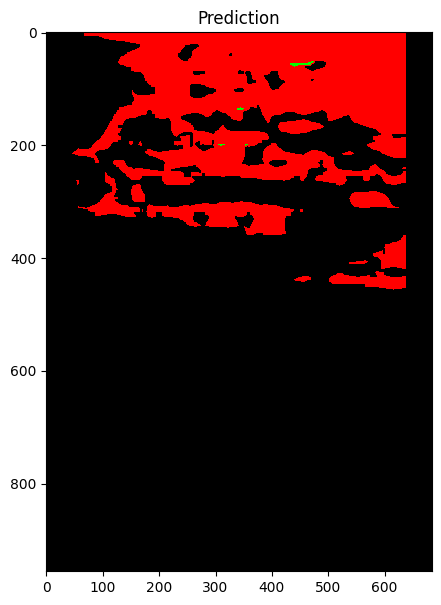

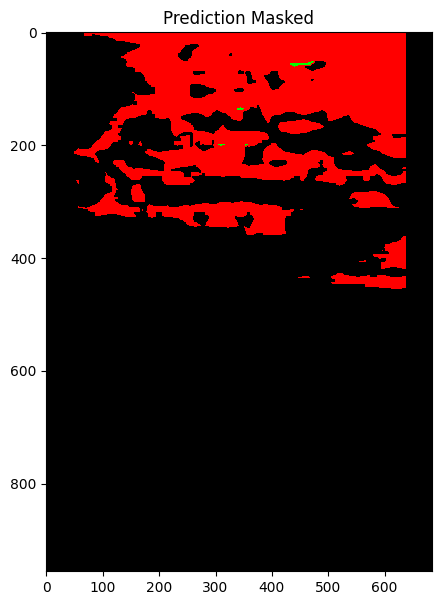

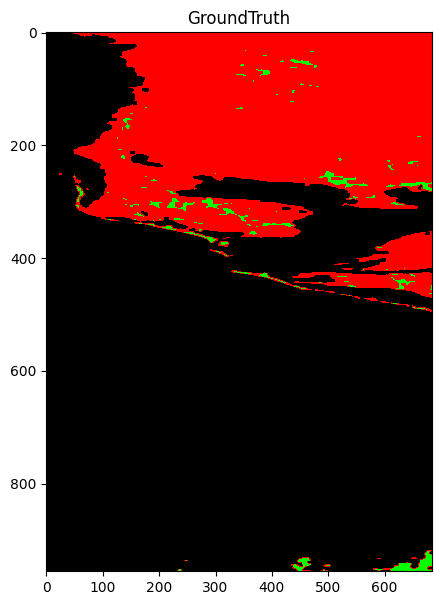

In [ ]:
def reconstruct_from_patches(patch_preds, test_images_shape, patch_size, stride):
    """
    Reconstructs the full test images from overlapping patch predictions.

    Args:
        patch_preds (np.array): Patch-wise predictions.
        test_images_shape (tuple): Shape of the full test dataset (num_images, H, W).
        patch_size (int): Size of the patches.
        stride (int): Stride used for patch extraction.

    Returns:
        np.array: Reconstructed full-size predicted images.
    """
    num_images, H, W = test_images_shape
    pred_map = np.zeros((num_images, H, W), dtype=np.float32)  # **Fixed: Use float32**
    count_map = np.zeros((num_images, H, W), dtype=np.float32)  # **Fixed: Also float32**

    patch_index = 0
    for img_idx in range(num_images):
        for i in range(0, H - patch_size + 1, stride):
            for j in range(0, W - patch_size + 1, stride):
                pred_map[img_idx, i:i+patch_size, j:j+patch_size] += patch_preds[patch_index].astype(np.float32)
                count_map[img_idx, i:i+patch_size, j:j+patch_size] += 1
                patch_index += 1

    # Avoid division by zero, normalize overlapping patch contributions
    count_map[count_map == 0] = 1
    pred_map = pred_map / count_map  # Average overlapping predictions

    return pred_map.astype(np.uint8)  # **Fixed: Convert final result to uint8**

# Define correct stride (usually patch_size // 2 for overlapping patches)
stride = PATCH_SIZE // 2  # Use the same stride as in training

# Reshape patches into full test images
pred_map = reconstruct_from_patches(predictions, testing_labels.shape, PATCH_SIZE, stride)

# **Visualize the predictions**
spectral.imshow(classes=pred_map[1], title='Prediction', figsize=(7,7))
spectral.imshow(classes=pred_map[1] * (testing_labels[1] != 0), title='Prediction Masked', figsize=(7,7))
spectral.imshow(classes=testing_labels[1], title='GroundTruth', figsize=(7,7))

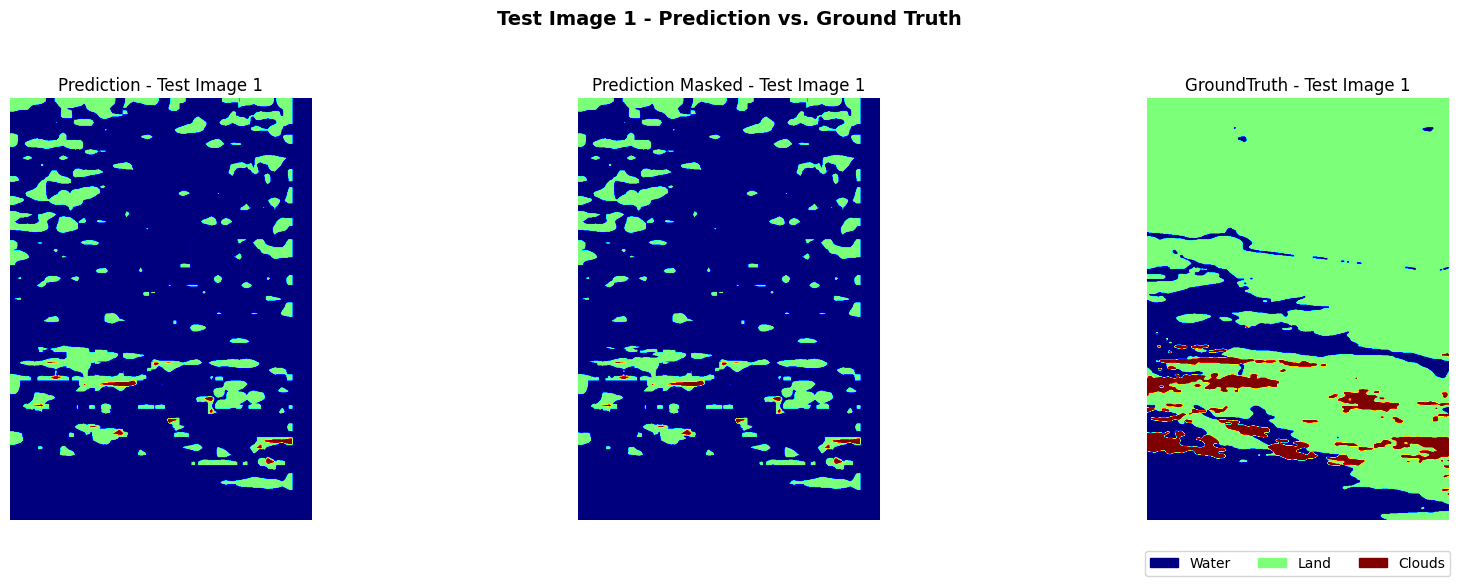

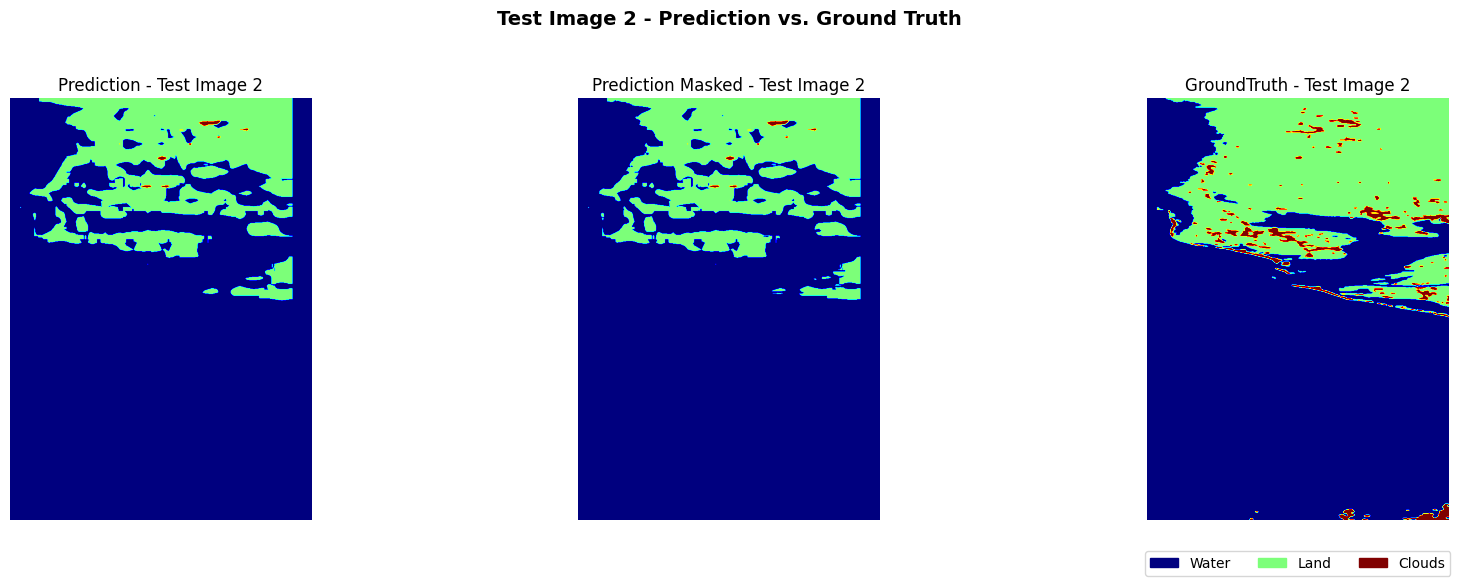

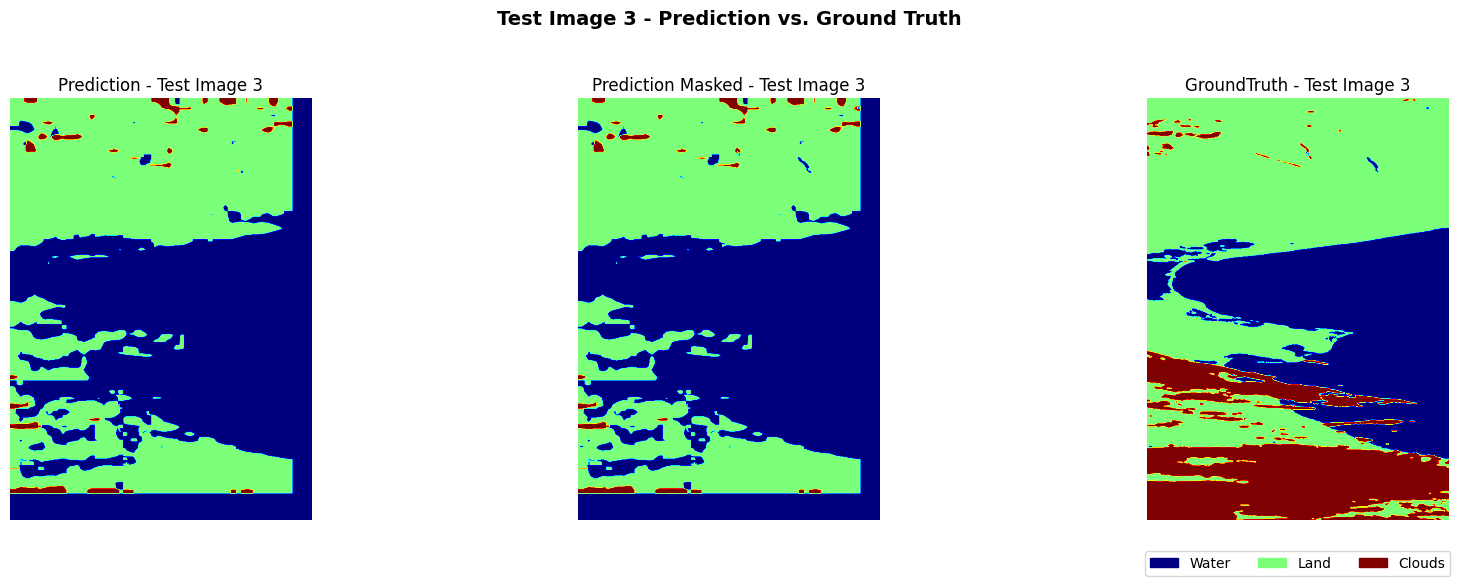

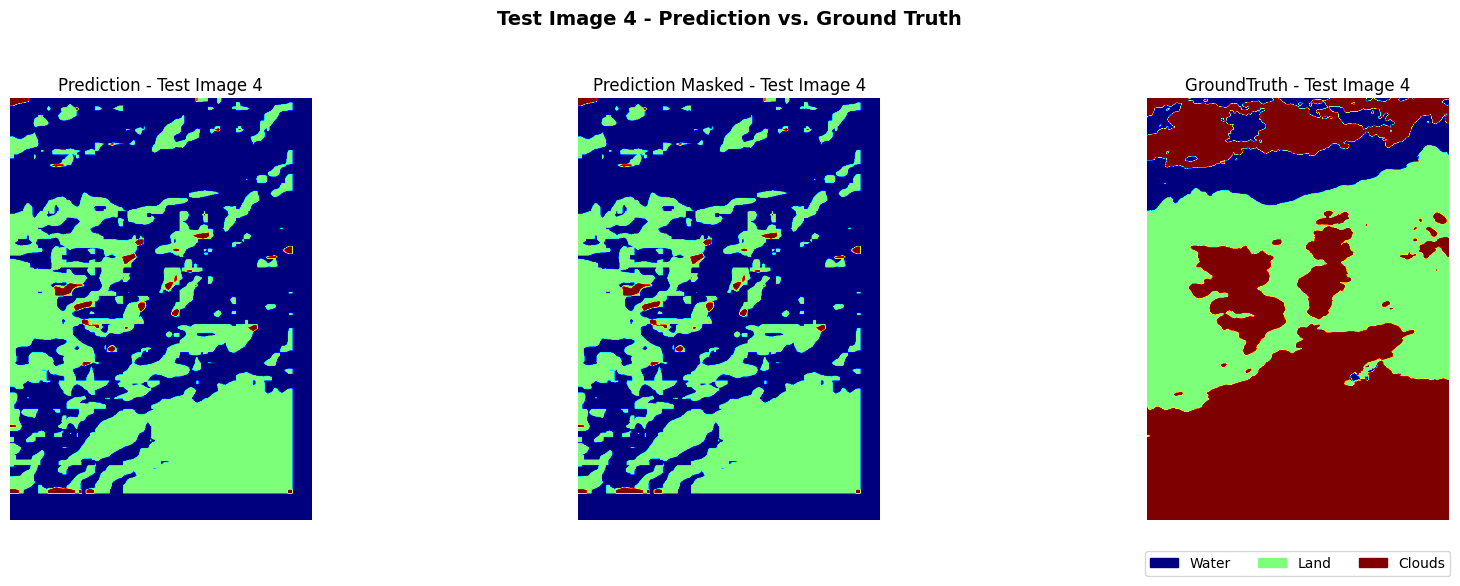

In [ ]:


# Define class names
class_names = {0: "Water", 1: "Land", 2: "Clouds"}  # Modify as needed
colormap = plt.cm.jet  # Use same colormap for consistency

# Ensure predictions are reshaped properly
pred_map = reconstruct_from_patches(predictions, testing_labels.shape, PATCH_SIZE, stride)

# Loop through test images for visualization
for img_idx in range(len(testing_data)):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

    # Extract corresponding ground truth and prediction
    ground_truth = testing_labels[img_idx]
    prediction = pred_map[img_idx]  # Use reconstructed prediction map
    masked_prediction = prediction * (ground_truth != 0)  # Mask to ignore background

    # Display Prediction
    im_pred = axes[0].imshow(prediction, cmap=colormap)
    axes[0].set_title(f'Prediction - Test Image {img_idx+1}')
    axes[0].axis('off')

    # Display Masked Prediction
    im_masked_pred = axes[1].imshow(masked_prediction, cmap=colormap)
    axes[1].set_title(f'Prediction Masked - Test Image {img_idx+1}')
    axes[1].axis('off')

    # Display Ground Truth
    im_gt = axes[2].imshow(ground_truth, cmap=colormap)
    axes[2].set_title(f'GroundTruth - Test Image {img_idx+1}')
    axes[2].axis('off')

    # Extract unique labels present in the images
    unique_labels = np.unique(np.concatenate((ground_truth, prediction)))

    # Create legend with corresponding colors
    patches = [
        mpatches.Patch(color=colormap(label_val / max(unique_labels)), label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]

    # Add legend below GroundTruth
    axes[2].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

    plt.suptitle(f'Test Image {img_idx+1} - Prediction vs. Ground Truth', fontsize=14, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


## Evaluation

In [ ]:
for img_idx in range(len(testing_data)):  # Loop through each test image
    test_pred = pred_map[img_idx].flatten()  # Flatten the predicted labels
    test_true = testing_labels[img_idx].flatten()  # Flatten the ground truth labels

    # Compute Evaluation Metrics
    OA = accuracy_score(test_true, test_pred)  # Overall Accuracy
    AA = recall_score(test_true, test_pred, average='macro')  # Average Accuracy (Class-wise)
    kappa = cohen_kappa_score(test_true, test_pred)  # Kappa Score

    # Print Evaluation Metrics
    print(f"\nTest Image {img_idx + 1}:")
    print("=" * 50)
    print(f"Overall Accuracy (OA): {OA:.4f}")
    print(f"Average Accuracy (AA): {AA:.4f}")
    print(f"Kappa Score: {kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_true, test_pred, target_names=list(class_names.values()), digits=4, zero_division=0))
    print("=" * 50)


Test Image 1:
Overall Accuracy (OA): 0.3510
Average Accuracy (AA): 0.4017
Kappa Score: 0.0720

Classification Report:
              precision    recall  f1-score   support

       Water     0.2735    0.9905    0.4287    155345
        Land     0.8265    0.1596    0.2675    461283
      Clouds     0.9056    0.0550    0.1038     37276

    accuracy                         0.3510    653904
   macro avg     0.6685    0.4017    0.2667    653904
weighted avg     0.6997    0.3510    0.2965    653904


Test Image 2:
Overall Accuracy (OA): 0.8798
Average Accuracy (AA): 0.5593
Kappa Score: 0.6892

Classification Report:
              precision    recall  f1-score   support

       Water     0.8648    0.9971    0.9262    455015
        Land     0.9438    0.6629    0.7788    183049
      Clouds     0.4058    0.0178    0.0341     15840

    accuracy                         0.8798    653904
   macro avg     0.7381    0.5593    0.5797    653904
weighted avg     0.8758    0.8798    0.8634    653904



In [ ]:
test_pred = pred_map.flatten()  # Flatten the predicted labels
test_true = testing_labels.flatten()  # Flatten the ground truth labels

# Compute Evaluation Metrics
OA = accuracy_score(test_true, test_pred)  # Overall Accuracy
AA = recall_score(test_true, test_pred, average='macro')  # Average Accuracy (Class-wise)
kappa = cohen_kappa_score(test_true, test_pred)  # Kappa Score

# Log Evaluation Metrics
report_log = f"OA: {OA:.4f}\nAA: {AA:.4f}\nKappa: {kappa:.4f}\n"
report_log += classification_report(test_true, test_pred, target_names=list(class_names.values()), digits=4, zero_division=0)

# Print Results
print(report_log)

# Save Results to File
save_path = os.path.join(SAVE_PATH, 'classification_report.txt')
with open(save_path, 'w') as fp:
    fp.write(report_log)

print(f"Classification report saved to {save_path}")

OA: 0.5366
AA: 0.4829
Kappa: 0.2632
              precision    recall  f1-score   support

       Water     0.4791    0.9963    0.6470    884594
        Land     0.6723    0.4265    0.5219   1191805
      Clouds     0.7022    0.0260    0.0501    539217

    accuracy                         0.5366   2615616
   macro avg     0.6179    0.4829    0.4064   2615616
weighted avg     0.6131    0.5366    0.4670   2615616

Classification report saved to results\SLC\classification_report.txt


### Confusion Matrix

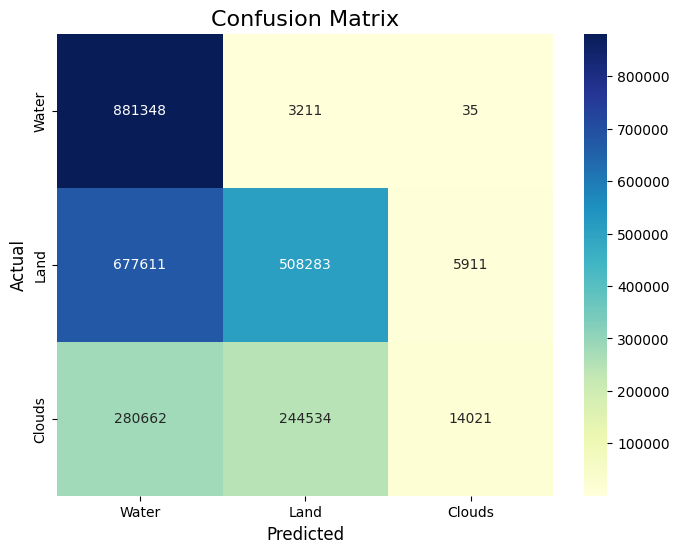

Training completed in 1207.89 seconds.
Completed in 1223.91 seconds.


In [ ]:
test_true_all = testing_labels.flatten()
test_pred_all = pred_map.flatten()

# Map unique class labels to indices (ensures correct ordering)
unique_classes = np.unique(test_true_all)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}

# Remap labels to match indices
test_true_remapped = np.array([class_mapping[val] for val in test_true_all])
test_pred_remapped = np.array([class_mapping[val] for val in test_pred_all])

# Compute Confusion Matrix
cm = confusion_matrix(test_true_remapped, test_pred_remapped)

# Get class names in the correct order
class_labels = [class_names[cls] for cls in unique_classes]

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Print completion time
total_time = time.time() - start_time
print(f"Training completed in {total_training_time:.2f} seconds.")
print(f"Completed in {total_time:.2f} seconds.")